In [99]:
import pandas as pd
import numpy as np

from utils import SentenceGetter
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, MaxPooling1D
from keras_contrib.layers import CRF
from keras.initializers import RandomUniform

import matplotlib.pyplot as plt




# Implement BiLSTM-CNN on data
At this part we are going to implement Named Entity Recognition with Bidirectional LSTM-CNNs based on the work <a href="https://arxiv.org/pdf/1511.08308.pdf">Chiu, J. P., & Nichols, E. (2016).</a> and then we expand this model to the BiLSTM-CNN-CRF model.  The overall network for BiLSTM-CNN model is presented on the figure below, however, we simplified it.

<table><tr>
<td> <img src="images/LSTM-CNN-1.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="images/LSTM-CNN-2.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="images/LSTM-CNN-3.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

We are going to:
1. Apply char embeddings by creating a dictionary of all characters and then mapping the ids to each character
2. Apply word embeddings by the same algorithm. Chiu and Nicols used GloVe word embeddings trained on 6 billions tokens from Wikipedia and Gigaword 5 (<a  href="https://nlp.stanford.edu/projects/glove/">Pennington et al., 2014. GloVe: Global Vectors for Word Representation.</a>), however, it does not contain all word representations for our dataset, therefore, it was decided not to use it. 
4. Apply CNN on char embeddings. We will try 2 different layers: 1) simple LSTM layer; 2) convolutional and max pooling layers (as it is described on fig.2).
5. Feed the output of CNN and word embeddings to the BiLSTM.
6. *For BiLSTM-CNN-CRF model, apply a CRF layer on top of created model.

## 0. Prepare data

In [100]:
#download data
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.tail(10)

Sentence #       Word  POS    Tag
1048565  Sentence: 47958     impact   NN      O
1048566  Sentence: 47958          .    .      O
1048567  Sentence: 47959     Indian   JJ  B-gpe
1048568  Sentence: 47959     forces  NNS      O
1048569  Sentence: 47959       said  VBD      O
1048570  Sentence: 47959       they  PRP      O
1048571  Sentence: 47959  responded  VBD      O
1048572  Sentence: 47959         to   TO      O
1048573  Sentence: 47959        the   DT      O
1048574  Sentence: 47959     attack   NN      O

In [101]:
#create a getter which will transform sentences
getter = SentenceGetter(data)

In [102]:
sentences = getter.sentences
sentences[3]

[['They', 'O'],
 ['left', 'O'],
 ['after', 'O'],
 ['a', 'O'],
 ['tense', 'O'],
 ['hour-long', 'O'],
 ['standoff', 'O'],
 ['with', 'O'],
 ['riot', 'O'],
 ['police', 'O'],
 ['.', 'O']]

In [104]:
words = list(set(data["Word"].values))

### Create Mappings for Words, Characters and Tags
 We now have a list of sentences which are words along with their labels. Now, we want to map these individual words, labels and characters in each word, to unique numerical ID's so that each unique word, character and tag in the vocabulary is represented by a particular integer ID. To do this, we first create a functions that do these mapping for us

### Why mapping is important?
These indices for words, labels and characters help us employ matrix (tensor) operations inside the neural network architecture, which are considerably faster.

## 1. Char embeddings

In [53]:
chars = set([w_i for w in words for w_i in w])
print(chars)
print(len(chars))

{'&', 'F', '\x97', '\x93', '!', 'K', 'f', 'U', 'M', 'y', 'k', '5', 'H', 'I', '\x91', 'S', 'ü', 'j', '?', '\xa0', 'n', 'D', 'L', '"', 'm', 'u', '-', 'T', ',', '0', '7', 'o', '%', 'l', '1', ']', '#', '(', '\x85', '~', 'v', ':', 'p', 'z', '3', 'b', 't', '2', '\x96', 'i', 'e', 'w', 'ë', 'h', 'g', "'", '9', '[', '°', '.', 'V', 'J', '$', '\x94', 'd', ')', 'O', '\x92', 'Q', 'B', '/', 'P', 'R', 'q', 'Y', 'ö', 'C', 'N', '6', 'a', '8', 'x', 's', 'W', 'Z', 'G', 'é', 'c', 'A', '@', '_', 'E', '+', 'X', ';', 'r', '`', '4'}
98


In [54]:
# Crate a mapping for characters
char2idx = {c: i + 1 for i, c in enumerate(chars)}
char2idx["PAD"] = 0 #use zero as a padding value
char2idx

{'&': 1,
 'F': 2,
 '\x97': 3,
 '\x93': 4,
 '!': 5,
 'K': 6,
 'f': 7,
 'U': 8,
 'M': 9,
 'y': 10,
 'k': 11,
 '5': 12,
 'H': 13,
 'I': 14,
 '\x91': 15,
 'S': 16,
 'ü': 17,
 'j': 18,
 '?': 19,
 '\xa0': 20,
 'n': 21,
 'D': 22,
 'L': 23,
 '"': 24,
 'm': 25,
 'u': 26,
 '-': 27,
 'T': 28,
 ',': 29,
 '0': 30,
 '7': 31,
 'o': 32,
 '%': 33,
 'l': 34,
 '1': 35,
 ']': 36,
 '#': 37,
 '(': 38,
 '\x85': 39,
 '~': 40,
 'v': 41,
 ':': 42,
 'p': 43,
 'z': 44,
 '3': 45,
 'b': 46,
 't': 47,
 '2': 48,
 '\x96': 49,
 'i': 50,
 'e': 51,
 'w': 52,
 'ë': 53,
 'h': 54,
 'g': 55,
 "'": 56,
 '9': 57,
 '[': 58,
 '°': 59,
 '.': 60,
 'V': 61,
 'J': 62,
 '$': 63,
 '\x94': 64,
 'd': 65,
 ')': 66,
 'O': 67,
 '\x92': 68,
 'Q': 69,
 'B': 70,
 '/': 71,
 'P': 72,
 'R': 73,
 'q': 74,
 'Y': 75,
 'ö': 76,
 'C': 77,
 'N': 78,
 '6': 79,
 'a': 80,
 '8': 81,
 'x': 82,
 's': 83,
 'W': 84,
 'Z': 85,
 'G': 86,
 'é': 87,
 'c': 88,
 'A': 89,
 '@': 90,
 '_': 91,
 'E': 92,
 '+': 93,
 'X': 94,
 ';': 95,
 'r': 96,
 '`': 97,
 '4': 98,
 'PAD

In [55]:
#map every word to a sequence of character numbers and pad the words 

X_char = []
#maximum length of batch of sentences
max_len = 75
#maximun length of the batch of characters
max_len_char = 10

for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [56]:
print(sentences[0])
print(X_char[0])

[['Thousands', 'O'], ['of', 'O'], ['demonstrators', 'O'], ['have', 'O'], ['marched', 'O'], ['through', 'O'], ['London', 'B-geo'], ['to', 'O'], ['protest', 'O'], ['the', 'O'], ['war', 'O'], ['in', 'O'], ['Iraq', 'B-geo'], ['and', 'O'], ['demand', 'O'], ['the', 'O'], ['withdrawal', 'O'], ['of', 'O'], ['British', 'B-gpe'], ['troops', 'O'], ['from', 'O'], ['that', 'O'], ['country', 'O'], ['.', 'O']]
[[28 54 32 26 83 80 21 65 83  0]
 [32  7  0  0  0  0  0  0  0  0]
 [65 51 25 32 21 83 47 96 80 47]
 [54 80 41 51  0  0  0  0  0  0]
 [25 80 96 88 54 51 65  0  0  0]
 [47 54 96 32 26 55 54  0  0  0]
 [23 32 21 65 32 21  0  0  0  0]
 [47 32  0  0  0  0  0  0  0  0]
 [43 96 32 47 51 83 47  0  0  0]
 [47 54 51  0  0  0  0  0  0  0]
 [52 80 96  0  0  0  0  0  0  0]
 [50 21  0  0  0  0  0  0  0  0]
 [14 96 80 74  0  0  0  0  0  0]
 [80 21 65  0  0  0  0  0  0  0]
 [65 51 25 80 21 65  0  0  0  0]
 [47 54 51  0  0  0  0  0  0  0]
 [52 50 47 54 65 96 80 52 80 34]
 [32  7  0  0  0  0  0  0  0  0]
 [70 96

## 2. Word embeddings

In [57]:
# Create a mapping for the labels (tags) and words
labelSet = set()
words = set()
for sentence in sentences:
    for token,label in sentence:
            labelSet.add(label)
            words.add(token)


label2Idx = {}
for label in labelSet:
    label2Idx[label] = len(label2Idx) +1
label2Idx["PAD"] = 0
    
word2Idx = {}
for word in words:
    word2Idx[word] = len(word2Idx)
word2Idx["PAD"] = 0

idx2label={i: l for l,i in label2Idx.items()}
idx2word = {i: w for w,i in word2Idx.items()}
    

In [58]:
label2Idx

{'B-eve': 1,
 'B-org': 2,
 'B-geo': 3,
 'O': 4,
 'I-per': 5,
 'B-nat': 6,
 'I-eve': 7,
 'I-tim': 8,
 'B-art': 9,
 'I-org': 10,
 'B-tim': 11,
 'B-per': 12,
 'I-gpe': 13,
 'I-geo': 14,
 'I-nat': 15,
 'I-art': 16,
 'B-gpe': 17,
 'PAD': 0}

In [59]:
#map the words in each sentence to its id
X_word = [[word2Idx[w[0]] for w in s] for s in sentences]
print(X_word[0])

[5621, 27764, 14393, 31962, 13840, 31704, 5483, 30939, 12942, 25136, 18819, 14963, 1885, 32270, 21856, 25136, 6619, 27764, 14116, 3952, 21873, 23063, 25909, 25008]


In [60]:
#pad the sentences since for tensorflow we need sentences with equal length
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2Idx["PAD"], padding='post', truncating='post')
print(X_word[0])

[ 5621 27764 14393 31962 13840 31704  5483 30939 12942 25136 18819 14963
  1885 32270 21856 25136  6619 27764 14116  3952 21873 23063 25909 25008
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


## 3. Model training

In [61]:
#do the mapping and padding for the labal sequence
y = [[label2Idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=label2Idx["PAD"], padding='post', truncating='post')
y[0]

array([ 4,  4,  4,  4,  4,  4,  3,  4,  4,  4,  4,  4,  3,  4,  4,  4,  4,
        4, 17,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [62]:
#separate data to train and test data

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)


# Model with LSTM layer for char embeddings

In [63]:
# input and embedding for words
word_in_1 = Input(shape=(max_len,))
emb_word_1 = Embedding(input_dim=len(word2Idx), output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in_1)

# input and embeddings for characters
char_in_1 = Input(shape=(max_len, max_len_char,))
embed_char_out_1 = TimeDistributed(Embedding(input_dim=len(char2idx), output_dim=10,
                           embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_in_1)

# character LSTM to get word encodings by characters
char_enc_1 = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(embed_char_out_1)

# main LSTM
x = concatenate([emb_word_1, char_enc_1])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(len(label2Idx), activation="sigmoid"))(main_lstm)

model_1 = Model([word_in_1, char_in_1], out)

In [64]:
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=["acc"])
model_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 75, 10, 10)   990         input_6[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 75, 20)       703560      input_5[0][0]                    
____________________________________________________________________________________________

In [65]:
history_1 = model_1.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.2, verbose=1)

Train on 34530 samples, validate on 8633 samples
Epoch 1/10
34530/34530 [==============================] - 110s 3ms/step - loss: 0.0943 - acc: 0.9174 - val_loss: 0.0422 - val_acc: 0.9572
Epoch 2/10
34530/34530 [==============================] - 119s 3ms/step - loss: 0.0364 - acc: 0.9640 - val_loss: 0.0344 - val_acc: 0.9653
Epoch 3/10
34530/34530 [==============================] - 123s 4ms/step - loss: 0.0294 - acc: 0.9701 - val_loss: 0.0322 - val_acc: 0.9670
Epoch 4/10
34530/34530 [==============================] - 122s 4ms/step - loss: 0.0262 - acc: 0.9725 - val_loss: 0.0318 - val_acc: 0.9674
Epoch 5/10
34530/34530 [==============================] - 122s 4ms/step - loss: 0.0240 - acc: 0.9743 - val_loss: 0.0316 - val_acc: 0.9675
Epoch 6/10
34530/34530 [==============================] - 125s 4ms/step - loss: 0.0226 - acc: 0.9756 - val_loss: 0.0313 - val_acc: 0.9681
Epoch 7/10
34530/34530 [==============================] - 122s 4ms/step - loss: 0.0214 - acc: 0.9767 - val_loss: 0.0315 - v

In [66]:
hist_1 = pd.DataFrame(history_1.history)
hist_1

val_loss   val_acc      loss       acc
0  0.042198  0.957177  0.094314  0.917382
1  0.034391  0.965263  0.036379  0.964043
2  0.032238  0.967003  0.029406  0.970116
3  0.031757  0.967423  0.026185  0.972480
4  0.031587  0.967523  0.024014  0.974314
5  0.031251  0.968112  0.022637  0.975593
6  0.031519  0.967720  0.021399  0.976716
7  0.031386  0.968330  0.020610  0.977478
8  0.031467  0.967836  0.019673  0.978192
9  0.031764  0.968638  0.018870  0.979117

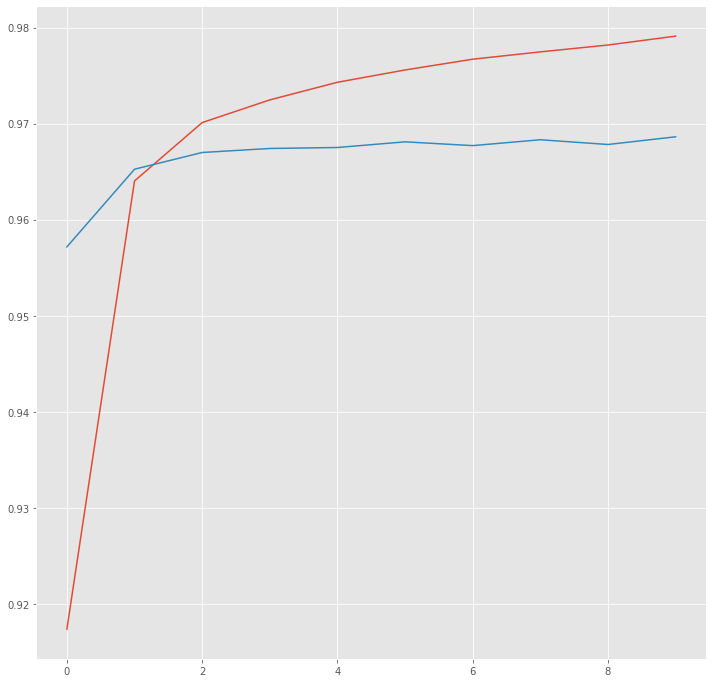

In [67]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist_1["acc"])
plt.plot(hist_1["val_acc"])
plt.show()

In [68]:
y_pred_1 = model_1.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [69]:
i = 1925
p = np.argmax(y_pred_1[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2label[t], idx2label[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-gpe
Foreign        : I-org O
Secretary      : B-per B-per
Jack           : I-per I-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-geo
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


In [108]:
y_true_test_1 = []
y_pred_test_1 = []
for i in range(len(y_pred_1)):
    p = np.argmax(y_pred_1[i], axis=-1)
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            y_true_test_1.append(idx2label[t])
            y_pred_test_1.append(idx2label[pred])

In [109]:
report_1 = classification_report(y_pred=y_pred_test_1, y_true=y_true_test_1)
print(report_1)

              precision    recall  f1-score   support

       B-art       0.42      0.10      0.16        49
       B-eve       0.75      0.27      0.40        33
       B-geo       0.85      0.91      0.88      3735
       B-gpe       0.95      0.94      0.95      1596
       B-nat       0.83      0.22      0.34        23
       B-org       0.81      0.70      0.75      2071
       B-per       0.86      0.83      0.84      1694
       B-tim       0.92      0.87      0.90      2158
       I-art       0.00      0.00      0.00        42
       I-eve       0.33      0.12      0.18        33
       I-geo       0.81      0.81      0.81       707
       I-gpe       1.00      0.44      0.61        16
       I-nat       0.75      0.60      0.67         5
       I-org       0.81      0.80      0.80      1786
       I-per       0.86      0.89      0.88      1739
       I-tim       0.86      0.67      0.75       726
           O       0.99      0.99      0.99     89144

    accuracy              

In [114]:
print("F1-score: {:.1%}".format(f1_score(y_true_test_1, y_pred_test_1, average = "weighted")))

F1-score: 82.3%


# Model with Convolutional and MaxPooling layers for char embeddings

In [77]:
# input and embedding for words
word_in_2 = Input(shape=(max_len,), name='words_input')
emb_word_2 = Embedding(input_dim=len(word2Idx), output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in_2)

# input and embeddings for characters
char_in_2 = Input(shape=(max_len, max_len_char,), name='char_input')
embed_char_out_2 = TimeDistributed(Embedding(input_dim=len(char2idx), output_dim=10,
                           embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_in_2)

#the char embeddings are going through CNN and MaxPooling layer
dropout= Dropout(0.5)(embed_char_out_2)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=10, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# main LSTM
x_2 = concatenate([emb_word_2, char])
output = Bidirectional(LSTM(50, return_sequences=True, recurrent_dropout=0.6))(x_2)
output = TimeDistributed(Dense(len(label2Idx), activation='softmax'))(output)


model_2 = Model(inputs=[word_in_2, char_in_2], outputs=[output])



In [78]:
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=["acc"])
model_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 75, 10)       0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 75, 10, 10)   990         char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 75, 10, 10)   0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 75, 10, 10)   310         dropout_1[0][0]                  
____________________________________________________________________________________________

In [79]:
history_2 = model_2.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.2, verbose=1)

Train on 34530 samples, validate on 8633 samples
Epoch 1/10
34530/34530 [==============================] - 72s 2ms/step - loss: 0.0809 - acc: 0.9278 - val_loss: 0.0394 - val_acc: 0.9602
Epoch 2/10
34530/34530 [==============================] - 82s 2ms/step - loss: 0.0314 - acc: 0.9677 - val_loss: 0.0382 - val_acc: 0.9601
Epoch 3/10
34530/34530 [==============================] - 86s 2ms/step - loss: 0.0245 - acc: 0.9741 - val_loss: 0.0326 - val_acc: 0.9667
Epoch 4/10
34530/34530 [==============================] - 87s 3ms/step - loss: 0.0210 - acc: 0.9771 - val_loss: 0.0328 - val_acc: 0.9665
Epoch 5/10
34530/34530 [==============================] - 86s 2ms/step - loss: 0.0185 - acc: 0.9794 - val_loss: 0.0329 - val_acc: 0.9674
Epoch 6/10
34530/34530 [==============================] - 87s 3ms/step - loss: 0.0167 - acc: 0.9814 - val_loss: 0.0339 - val_acc: 0.9670
Epoch 7/10
34530/34530 [==============================] - 86s 2ms/step - loss: 0.0150 - acc: 0.9828 - val_loss: 0.0351 - val_acc:

In [80]:
y_pred_2 = model_2.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [81]:
hist_2 = pd.DataFrame(history_2.history)
hist_2

val_loss   val_acc      loss       acc
0  0.039424  0.960233  0.080878  0.927826
1  0.038221  0.960058  0.031392  0.967710
2  0.032580  0.966749  0.024476  0.974069
3  0.032816  0.966457  0.020982  0.977092
4  0.032919  0.967438  0.018542  0.979412
5  0.033855  0.967009  0.016667  0.981380
6  0.035098  0.966664  0.015040  0.982815
7  0.036669  0.966457  0.013643  0.984297
8  0.037827  0.965682  0.012584  0.985572
9  0.039582  0.965306  0.011499  0.986778

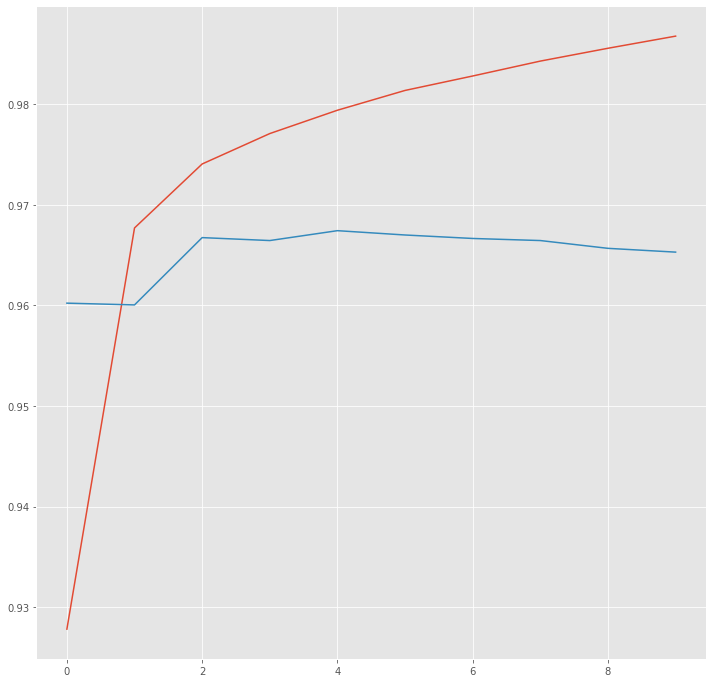

In [82]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist_2["acc"])
plt.plot(hist_2["val_acc"])
plt.show()

In [83]:
i = 1925
p = np.argmax(y_pred_2[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2label[t], idx2label[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-org
Foreign        : I-org I-org
Secretary      : B-per B-per
Jack           : I-per I-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


In [111]:
y_true_test_2 = []
y_pred_test_2 = []
for i in range(len(y_pred_2)):
    p = np.argmax(y_pred_2[i], axis=-1)
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            y_true_test_2.append(idx2label[t])
            y_pred_test_2.append(idx2label[pred])

In [112]:
report_2 = classification_report(y_pred=y_pred_test_2, y_true=y_true_test_2)
print(report_2)

              precision    recall  f1-score   support

       B-art       0.27      0.06      0.10        49
       B-eve       0.48      0.36      0.41        33
       B-geo       0.85      0.87      0.86      3735
       B-gpe       0.96      0.92      0.94      1596
       B-nat       0.38      0.52      0.44        23
       B-org       0.74      0.73      0.73      2071
       B-per       0.84      0.81      0.83      1694
       B-tim       0.92      0.87      0.89      2158
       I-art       0.25      0.02      0.04        42
       I-eve       0.24      0.18      0.21        33
       I-geo       0.80      0.77      0.78       707
       I-gpe       0.70      0.44      0.54        16
       I-nat       1.00      0.20      0.33         5
       I-org       0.78      0.77      0.77      1786
       I-per       0.86      0.86      0.86      1739
       I-tim       0.82      0.70      0.75       726
           O       0.99      0.99      0.99     89144

    accuracy              

In [115]:
print("F1-score: {:.1%}".format(f1_score(y_true_test_2, y_pred_test_2, average = "weighted")))

F1-score: 79.8%


# Expand the model to BiLSTM-CNN-CRF

In [87]:
from keras.utils import to_categorical
y_CRF = [to_categorical(i, num_classes=len(label2Idx)) for i in y]
y_CRF[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [88]:
X_word_tr_CRF, X_word_te_CRF, y_tr_CRF, y_te_CRF = train_test_split(X_word, y_CRF, test_size=0.1, random_state=2018)
X_char_tr_CRF, X_char_te_CRF, _, _ = train_test_split(X_char, y_CRF, test_size=0.1, random_state=2018)

In [89]:
# input and embedding for words
word_in_3 = Input(shape=(max_len,), name='words_input')
emb_word_3 = Embedding(input_dim=len(word2Idx), output_dim=20,
                     input_length=max_len)(word_in_3)

# input and embeddings for characters
char_in_3 = Input(shape=(max_len, max_len_char,), name='char_input')
embed_char_out_3 = TimeDistributed(Embedding(input_dim=len(char2idx), output_dim=10,
                           embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_in_3)

#the char embeddings are going through CNN and MaxPooling layer
dropout= Dropout(0.5)(embed_char_out_3)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=10, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# main LSTM
x_3 = concatenate([emb_word_3, char])
output_3 = Bidirectional(LSTM(50, return_sequences=True, recurrent_dropout=0.6))(x_3)
output_3 = TimeDistributed(Dense(50, activation=None))(output_3)


crf = CRF(len(label2Idx))
crf_output = crf(output_3)
model_3 = Model(inputs=[word_in_3, char_in_3], outputs=[crf_output])



In [90]:
model_3.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model_3.summary()

C:\Users\linar\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\linar\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 75, 10)       0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 75, 10, 10)   990         char_input[0][0]                 
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 75, 10, 10)   0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 75, 10, 10)   310         dropout_3[0][0]                  
____________________________________________________________________________________________

In [91]:
history_3 = model_3.fit([X_word_tr_CRF,
                     np.array(X_char_tr_CRF).reshape((len(X_char_tr_CRF), max_len, max_len_char))],
                    np.array(y_tr_CRF),
                    batch_size=32, epochs=10, validation_split=0.2, verbose=1)

Train on 34530 samples, validate on 8633 samples
Epoch 1/10
34530/34530 [==============================] - 131s 4ms/step - loss: 0.1190 - crf_viterbi_accuracy: 0.9667 - val_loss: 0.0338 - val_crf_viterbi_accuracy: 0.9860
Epoch 2/10
34530/34530 [==============================] - 135s 4ms/step - loss: 0.0168 - crf_viterbi_accuracy: 0.9882 - val_loss: 0.0070 - val_crf_viterbi_accuracy: 0.9887
Epoch 3/10
34530/34530 [==============================] - 135s 4ms/step - loss: -0.0059 - crf_viterbi_accuracy: 0.9902 - val_loss: -0.0120 - val_crf_viterbi_accuracy: 0.9897
Epoch 4/10
34530/34530 [==============================] - 134s 4ms/step - loss: -0.0238 - crf_viterbi_accuracy: 0.9911 - val_loss: -0.0289 - val_crf_viterbi_accuracy: 0.9902
Epoch 5/10
34530/34530 [==============================] - 133s 4ms/step - loss: -0.0402 - crf_viterbi_accuracy: 0.9917 - val_loss: -0.0440 - val_crf_viterbi_accuracy: 0.9901
Epoch 6/10
34530/34530 [==============================] - 133s 4ms/step - loss: -0.05

In [92]:
y_pred_3 = model_3.predict([X_word_te_CRF,
                        np.array(X_char_te_CRF).reshape((len(X_char_te_CRF),
                                                     max_len, max_len_char))])

In [93]:
hist_3 = pd.DataFrame(history_3.history)
hist_3

val_loss  val_crf_viterbi_accuracy      loss  crf_viterbi_accuracy
0  0.033828                  0.985956  0.118974              0.966704
1  0.006960                  0.988660  0.016765              0.988166
2 -0.012034                  0.989704 -0.005882              0.990208
3 -0.028918                  0.990151 -0.023789              0.991128
4 -0.043978                  0.990117 -0.040241              0.991720
5 -0.058658                  0.990592 -0.055927              0.992157
6 -0.073528                  0.990796 -0.071290              0.992436
7 -0.088432                  0.990742 -0.086391              0.992799
8 -0.102778                  0.990763 -0.101402              0.993002
9 -0.117289                  0.990869 -0.116401              0.993214

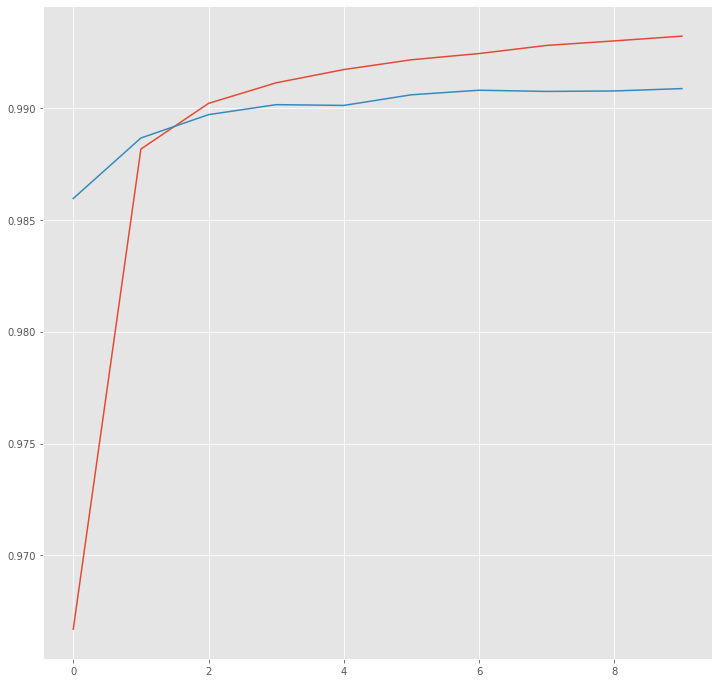

In [94]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist_3["crf_viterbi_accuracy"])
plt.plot(hist_3["val_crf_viterbi_accuracy"])
plt.show()

In [95]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2label[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(y_pred_3)
test_labels = pred2label(y_te_CRF)


In [116]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels, average="weighted")))

F1-score: 83.9%


In [128]:
from sklearn_crfsuite.metrics import flat_classification_report
print(flat_classification_report(test_labels, pred_labels))

C:\Users\linar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        49
       B-eve       0.59      0.30      0.40        33
       B-geo       0.86      0.90      0.88      3735
       B-gpe       0.96      0.94      0.95      1596
       B-nat       0.46      0.26      0.33        23
       B-org       0.81      0.71      0.75      2071
       B-per       0.84      0.84      0.84      1694
       B-tim       0.93      0.85      0.89      2158
       I-art       0.00      0.00      0.00        42
       I-eve       0.43      0.18      0.26        33
       I-geo       0.81      0.81      0.81       707
       I-gpe       0.91      0.62      0.74        16
       I-nat       0.00      0.00      0.00         5
       I-org       0.82      0.77      0.79      1786
       I-per       0.84      0.93      0.88      1739
       I-tim       0.89      0.66      0.75       726
           O       1.00      1.00      1.00    343287

    accuracy              

In [98]:
i = 1925
p = np.argmax(y_pred_3[i], axis=-1)
true = np.argmax(y_te_CRF[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te_CRF[i], true, p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2label[t], idx2label[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-org
Foreign        : I-org I-org
Secretary      : B-per B-per
Jack           : I-per I-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


# LSTM-LSTM-CRF 
Try the LSTM layer for char embeddings, biLSTM and CRF.

In [118]:
# input and embedding for words
word_in_4 = Input(shape=(max_len,), name='words_input')
emb_word_4 = Embedding(input_dim=len(word2Idx), output_dim=20,
                     input_length=max_len)(word_in_4)

# input and embeddings for characters
char_in_4 = Input(shape=(max_len, max_len_char,), name='char_input')
embed_char_out_4 = TimeDistributed(Embedding(input_dim=len(char2idx), output_dim=10,
                           embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_in_4)

# character LSTM to get word encodings by characters
char_enc_4 = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(embed_char_out_4)

# main LSTM
x_4 = concatenate([emb_word_4, char_enc_4])
output_4 = Bidirectional(LSTM(50, return_sequences=True, recurrent_dropout=0.6))(x_4)
output_4 = TimeDistributed(Dense(50, activation=None))(output_4)


crf = CRF(len(label2Idx))
crf_output = crf(output_4)
model_4 = Model(inputs=[word_in_4, char_in_4], outputs=[crf_output])



In [119]:
model_4.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model_4.summary()

C:\Users\linar\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\linar\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 75, 10)       0                                            
__________________________________________________________________________________________________
words_input (InputLayer)        (None, 75)           0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 75, 10, 10)   990         char_input[0][0]                 
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 75, 20)       703560      words_input[0][0]                
____________________________________________________________________________________________

In [120]:
history_4 = model_4.fit([X_word_tr_CRF,
                     np.array(X_char_tr_CRF).reshape((len(X_char_tr_CRF), max_len, max_len_char))],
                    np.array(y_tr_CRF),
                    batch_size=32, epochs=10, validation_split=0.2, verbose=1)

Train on 34530 samples, validate on 8633 samples
Epoch 1/10
34530/34530 [==============================] - 304s 9ms/step - loss: 0.1036 - crf_viterbi_accuracy: 0.9693 - val_loss: 0.0259 - val_crf_viterbi_accuracy: 0.9872
Epoch 2/10
34530/34530 [==============================] - 310s 9ms/step - loss: 0.0098 - crf_viterbi_accuracy: 0.9891 - val_loss: -7.4405e-04 - val_crf_viterbi_accuracy: 0.9896
Epoch 3/10
34530/34530 [==============================] - 307s 9ms/step - loss: -0.0116 - crf_viterbi_accuracy: 0.9909 - val_loss: -0.0183 - val_crf_viterbi_accuracy: 0.9902
Epoch 4/10
34530/34530 [==============================] - 308s 9ms/step - loss: -0.0290 - crf_viterbi_accuracy: 0.9915 - val_loss: -0.0325 - val_crf_viterbi_accuracy: 0.9899
Epoch 5/10
34530/34530 [==============================] - 307s 9ms/step - loss: -0.0452 - crf_viterbi_accuracy: 0.9920 - val_loss: -0.0493 - val_crf_viterbi_accuracy: 0.9908
Epoch 6/10
34530/34530 [==============================] - 303s 9ms/step - loss: 

In [121]:
y_pred_4 = model_4.predict([X_word_te_CRF,
                        np.array(X_char_te_CRF).reshape((len(X_char_te_CRF),
                                                     max_len, max_len_char))])

In [122]:
hist_4 = pd.DataFrame(history_4.history)
hist_4

val_loss  val_crf_viterbi_accuracy      loss  crf_viterbi_accuracy
0  0.025908                  0.987201  0.103602              0.969258
1 -0.000744                  0.989624  0.009788              0.989077
2 -0.018339                  0.990237 -0.011620              0.990865
3 -0.032522                  0.989925 -0.029047              0.991497
4 -0.049328                  0.990839 -0.045222              0.992049
5 -0.065016                  0.991050 -0.060719              0.992434
6 -0.079241                  0.990664 -0.075989              0.992757
7 -0.094238                  0.990984 -0.091087              0.992989
8 -0.108483                  0.990990 -0.106013              0.993159
9 -0.122532                  0.990621 -0.120996              0.993434

In [130]:
  
pred_labels = pred2label(y_pred_4)
test_labels = pred2label(y_te_CRF)


In [131]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels, average="weighted")))
print(flat_classification_report(test_labels, pred_labels))

F1-score: 84.1%
              precision    recall  f1-score   support

       B-art       0.75      0.06      0.11        49
       B-eve       0.29      0.30      0.30        33
       B-geo       0.84      0.93      0.88      3735
       B-gpe       0.98      0.92      0.95      1596
       B-nat       0.50      0.35      0.41        23
       B-org       0.80      0.73      0.76      2071
       B-per       0.88      0.82      0.85      1694
       B-tim       0.90      0.89      0.89      2158
       I-art       0.00      0.00      0.00        42
       I-eve       0.21      0.27      0.24        33
       I-geo       0.74      0.86      0.80       707
       I-gpe       1.00      0.44      0.61        16
       I-nat       0.50      0.20      0.29         5
       I-org       0.77      0.84      0.80      1786
       I-per       0.86      0.90      0.88      1739
       I-tim       0.74      0.77      0.75       726
           O       1.00      1.00      1.00    343287

    accura